# Predict My Own Potential Salary

### Adam Forestier
**Last Updated** - September 27, 2023

### Problem Statement
I am in the job market and seeking roles as a data scientist or data analyst. I have a few years of experience as a software developer, held a brief research assistant position at my university in the data space, and have a taken a combination of courses at my university, as well as on platforms such as Udemy. I want to know what I should be asking for, regarding my salary with the aforementioned attributes. I will be training regressors and then selecting the model with the most favorable Root Mean Squared Error to plug my personal features into to receive my approximate salary worth.

This notebook is for myself only. It is a place where I am running some high level experiments with regression models to see what effects model performance on data that needs vast amounts of feature engineering. Due to me only doing this for experimental purposes, I will not bother with feature engineering or outlier removal. I know this needs to take place, but am only exploring model changes


In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from joblib import dump
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import (SelectKBest, mutual_info_regression)
from sklearn.linear_model import (ElasticNetCV, LinearRegression)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.preprocessing import (PolynomialFeatures, StandardScaler)
from xgboost import XGBRegressor

file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)

In [163]:
warnings.filterwarnings(action='ignore')

## Functions & Constants

In [164]:
# Constants
LABEL = 'salary_in_usd'

In [165]:
def run_model(model_type, model, X_train, X_test, y_train, y_test) -> dict:
    """
    Fit a machine learning model on training data, perform predictions on test data,
    and return a dictionary containing the model's name and its root mean squared error (RMSE).

    Parameters:
        model_type (str): A string representing the name or type of the machine learning model.
        model (object): The machine learning model to be trained and evaluated.
        X_train (array-like): Training feature data.
        X_test (array-like): Test feature data.
        y_train (array-like): Training target data.
        y_test (array-like): Test target data.

    Returns:
        dict: A dictionary containing the model type as the key and its RMSE as the value.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    rmse_str = '$' + str(rmse)
    return {model_type: rmse_str}

## Initial Data Investigation, Cleansing & Feature Engineering

In [166]:
df = pd.read_csv(file)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


**Notes**: 
- There are no null objects in this dataset
- Total of 3755 Entries
- Many features are currently of type object - They will need to converted to categorical data types to increase model performance. 
- Features to convert to categorical: experience_level, employment_type, job_title, salary_currency, employee_residence, remote_ratio, company_location, company_size (Important: CatBoost, XGBoost & LightGBM handle categorical features well, many other ML algorithms would need the data to be turned into numeric data)
- Meanwhile work_year is in fact a discrete variable, and should not function like a numeric in this specific data set (there are no in between numbers and a discrete year range). It will need to become of type object, and then turned into a binary selection for each year
- I am trying to predict my salary in USD, thus I will not have "salary" available to me when making my prediction. I will remove it from the feature set

In [168]:
# Let's go ahead and remove salary, since we will be predicting salary in USD
df = df.drop(['salary'], axis=1)
df.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,USD,120000,CA,100,CA,M


In [169]:
# Remove all duplicates - (hopefully none) and then check the length of the dataframe
l = len(df)
df = df.drop_duplicates()
print(f'{l - len(df)} duplicates removed. \n\nDataset has {len(df)} unique entries')

1171 duplicates removed. 

Dataset has 2584 unique entries


**NOTE** - This dataset contained quite a few duplicates

In [170]:
# With Duplicates removed, let's change columns to appropriate datatypes. Let's also
columns = list(df.columns)
for col_name in columns:
    if col_name == 'work_year':
        df[col_name] = df[col_name].astype('category')
    else:
        if df[col_name].dtype != 'int64':
            df[col_name] = df[col_name].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           2584 non-null   category
 1   experience_level    2584 non-null   category
 2   employment_type     2584 non-null   category
 3   job_title           2584 non-null   category
 4   salary_currency     2584 non-null   category
 5   salary_in_usd       2584 non-null   int64   
 6   employee_residence  2584 non-null   category
 7   remote_ratio        2584 non-null   int64   
 8   company_location    2584 non-null   category
 9   company_size        2584 non-null   category
dtypes: category(8), int64(2)
memory usage: 90.2 KB


In [171]:
# summary stats for our salary & remote ratio
df.describe()

,salary_in_usd,remote_ratio
count,2584.000000,2584.000000
mean,133409.280186,50.483746
std,67136.837329,48.163707
min,5132.000000,0.000000
25%,84975.000000,0.000000
50%,130000.000000,50.000000
75%,175000.000000,100.000000
max,450000.000000,100.000000


In [172]:
# Now let's see the value count for each categorical column has
for col_name in columns:
    if df[col_name].dtype == 'category':
        print(f'{df[col_name].value_counts()}\n')

work_year
2023    1156
2022    1125
2021     228
2020      75
Name: count, dtype: int64

experience_level
SE    1554
MI     664
EN     270
EX      96
Name: count, dtype: int64

employment_type
FT    2547
PT      17
CT      10
FL      10
Name: count, dtype: int64

job_title
Data Engineer                598
Data Scientist               538
Data Analyst                 396
Machine Learning Engineer    206
Analytics Engineer            91
                            ... 
Compliance Data Analyst        1
Cloud Data Architect           1
BI Data Engineer               1
Azure Data Engineer            1
Staff Data Scientist           1
Name: count, Length: 93, dtype: int64

salary_currency
USD    2107
EUR     200
GBP     144
INR      59
CAD      25
AUD       9
BRL       6
SGD       6
PLN       5
CHF       4
DKK       3
JPY       3
TRY       3
HUF       3
THB       2
CZK       1
CLP       1
HKD       1
ILS       1
MXN       1
Name: count, dtype: int64

employee_residence
US    1893
GB     150


In [173]:
# Now let's see how many unique values there are for each categorical column
for col_name in columns:
    if df[col_name].dtype == 'category':
        print(f'{col_name}: {df[col_name].nunique()}')

work_year: 4
experience_level: 4
employment_type: 4
job_title: 93
salary_currency: 20
employee_residence: 78
company_location: 72
company_size: 3


## Exploratory Data Analysis through Visualization

### Investigate Outliers

Text(0.5, 1.0, 'Range of Salaries by Experience Level')

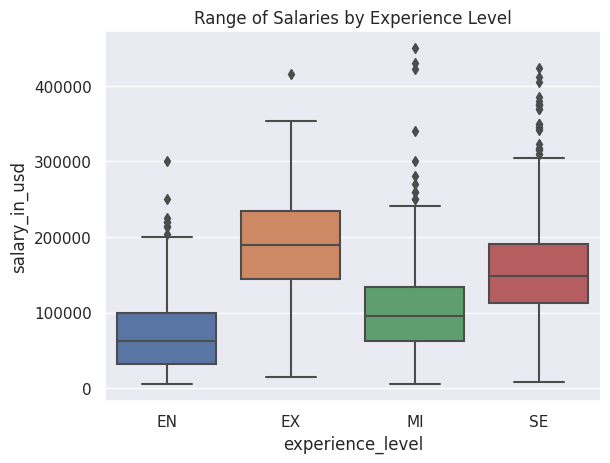

In [174]:
sns.set(style='darkgrid')
sns.boxplot(data=df, x='experience_level', y='salary_in_usd')
plt.title(label='Range of Salaries by Experience Level')

Text(0.5, 1.0, 'Range of Salaries by Experience Level')

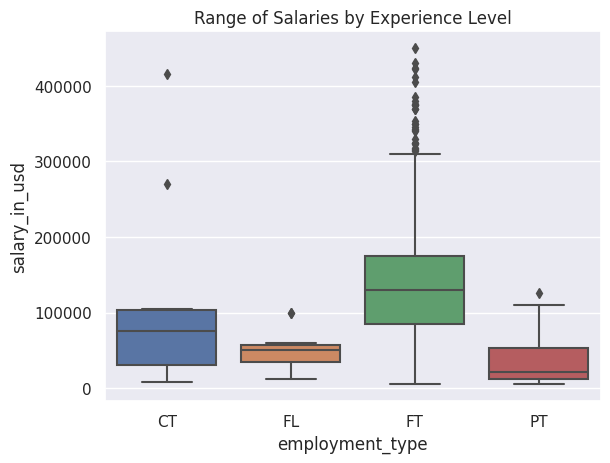

In [175]:
sns.set(style='darkgrid')
sns.boxplot(data=df, x='employment_type', y='salary_in_usd')
plt.title(label='Range of Salaries by Experience Level')

### Distribution of salaries

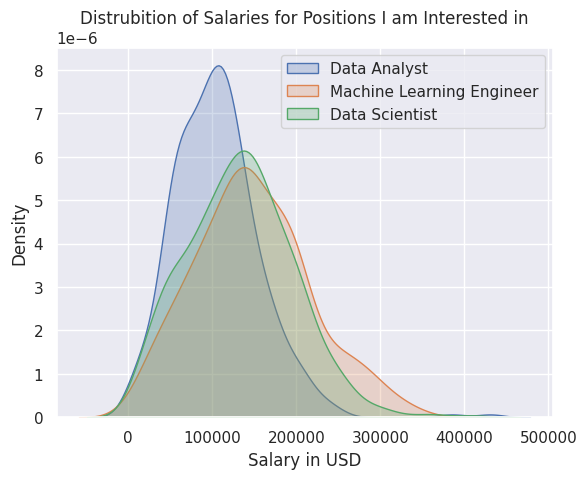

In [176]:
sns.set(style='darkgrid')
sns.kdeplot(x='salary_in_usd', data=df[df['job_title'] == 'Data Analyst'], fill=True, label='Data Analyst')
sns.kdeplot(x='salary_in_usd', data=df[df['job_title'] == 'Machine Learning Engineer'], fill=True, label='Machine Learning Engineer')
sns.kdeplot(x='salary_in_usd', data=df[df['job_title'] == 'Data Scientist'], fill=True, label='Data Scientist')
plt.title('Distrubition of Salaries for Positions I am Interested in')
plt.xlabel(xlabel='Salary in USD')
plt.legend()

## Train Models

### Split Data


In [177]:
# Features and label
X = df.drop([LABEL], axis=1)
y = df[LABEL]

In [178]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [179]:
# Get list of categorical columns to feed as categorical feature parameter to models
cat_cols = []
for col_name in columns:
    if df[col_name].dtype == 'category':
        cat_cols.append(col_name)

In [180]:
# Get average salary to use to compare to each model's RMSE
avg_salary = round(df[LABEL].mean(), 2)
print(f'Average Salary in USD: ${avg_salary}')

Average Salary in USD: $133409.28


### Most Basic Models
- No hyperparameter tuning
- No one-hot encoding or numerical assignments to categorical dtypes

In [181]:
# instantiate models
light_regressor = LGBMRegressor(objective='regression', random_state=42, categorical_feature=cat_cols, verbose=-1)
cat_regressor = CatBoostRegressor(random_state=42, cat_features=cat_cols, verbose=0)

In [182]:
# Test Base Model Performance using Root Mean Squared Error
light_rmse = run_model(model_type='LightGBM Regressor', model=light_regressor, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
cat_rmse = run_model(model_type='CatBoost Regressor', model=cat_regressor, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Linear Model with ElasticNet Regularization

In [183]:
X = pd.get_dummies(df.drop(labels=LABEL, axis=1), drop_first=True)
y = df[LABEL]

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
linear_model = ElasticNetCV(eps=0.001, cv=10, n_alphas=100, l1_ratio=[0.0001, .1, .5, .9, .95, 1], max_iter=100000)

In [185]:
# Test model performance
linear_rmse = run_model(model_type='Linear', model=model, X_train=scaled_X_train, X_test=scaled_X_test, y_train=y_train, y_test=y_test)

### Grid Searched Random Forest Regressor using KBest features  

In [186]:
X = df.drop(LABEL, axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [187]:
# Show most posivitvely correlated and most negatively correlated to label
tmp = pd.get_dummies(df, drop_first=True)
tmp_corr = tmp.corr()[LABEL].sort_values()
tmp_corr.head(), tmp_corr.tail()

(salary_currency_EUR     -0.297587
 experience_level_MI     -0.276679
 salary_currency_INR     -0.244617
 employee_residence_IN   -0.240803
 company_location_IN     -0.230277
 Name: salary_in_usd, dtype: float64,
 experience_level_SE      0.374915
 salary_currency_USD      0.472493
 company_location_US      0.484879
 employee_residence_US    0.507043
 salary_in_usd            1.000000
 Name: salary_in_usd, dtype: float64)

In [188]:
# Select 10 best features to train model
k_best = SelectKBest(score_func=mutual_info_regression, k=25)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

In [189]:
# model and rmse
base_regressor = RandomForestRegressor(n_estimators=100, oob_score=False, bootstrap=True)
param_grid = {
    'max_features': [3, 4, 5],
    'max_depth': [3, 4, 5]
}
model = GridSearchCV(estimator=base_regressor, param_grid=param_grid)

In [190]:
forest_rmse = run_model(model_type="Random Forest Regressor", model=model, X_train=X_train_selected, X_test=X_test_selected, y_train=y_train, y_test=y_test)

## Model Comparison

In [191]:
# Text
print(light_rmse)
print(cat_rmse)
print(linear_rmse)
print(forest_rmse)

{'LightGBM Regressor': '$51920.25'}
{'CatBoost Regressor': '$51845.63'}
{'Linear': '$59469.85'}
{'Random Forest Regressor': '$53889.94'}


## My Salary Predictions

In [192]:
# Export salary to make predictions
linear_model.fit(X_train, y_train)
dump(linear_model, 'ds_salary_prediction_model.joblib') 

['ds_salary_prediction_model.joblib']